In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!ls '/gdrive/My Drive/bambit/UrbanSound8K'
!cp -rf '/gdrive/My Drive/bambit/UrbanSound8K' /contents

audio  FREESOUNDCREDITS.txt  metadata  UrbanSound8K_README.txt


In [0]:

!ls /contents/audio

fold1  fold10  fold2  fold3  fold4  fold5  fold6  fold7  fold8	fold9


In [0]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = '/contents/audio/fold5/100852-0-0-0.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


In [0]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccsscaled

In [0]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/contents/audio/'

metadata = pd.read_csv('/contents/metadata/UrbanSound8K.csv')


In [0]:

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  8732  files


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

Using TensorFlow backend.


In [0]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [0]:

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)


In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [0]:
!ls /content

sample_data  saved_models


In [0]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 140us/step - loss: 1.4424 - acc: 0.5081 - val_loss: 1.2357 - val_acc: 0.6073

Epoch 00001: val_loss improved from inf to 1.23570, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
6985/6985 [==============================] - 1s 138us/step - loss: 1.3735 - acc: 0.5304 - val_loss: 1.1725 - val_acc: 0.6491

Epoch 00002: val_loss improved from 1.23570 to 1.17248, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
6985/6985 [==============================] - 1s 142us/step - loss: 1.3056 - acc: 0.5573 - val_loss: 1.1094 - val_acc: 0.6623

Epoch 00003: val_loss improved from 1.17248 to 1.10942, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 4/100
6985/6985 [==============================] - 1s 163us/step - loss: 1.2534 - acc: 0.5694 - val_loss: 1.0494 - val_acc: 0.6760

Epoch 00004: val_loss improved from 1.10942 to 1.04936, saving mo

In [0]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9294201861130995
Testing Accuracy:  0.8775042929032495


In [0]:
import librosa 
import numpy as np 

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [0]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [0]:
def print_noise_result(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    if predicted_class[0] == 'children_playing':
      noise_result = 2
    elif predicted_class[0] == 'siren':
      noise_result = 1
    else:
      noise_result = 0
    
    print("The predicted class is:", predicted_class[0], '\n') 
    print("The noise result is:", noise_result, '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [0]:
# Class: Air Conditioner

filename = '/contents/audio/fold5/100852-0-0-0.wav' 
print_noise_result(filename)

The predicted class is: air_conditioner 

The noise result is: 0 

air_conditioner 		 :  0.99878376722335815429687500000000
car_horn 		 :  0.00004398046439746394753456115723
children_playing 		 :  0.00014643651957157999277114868164
dog_bark 		 :  0.00001793673800420947372913360596
drilling 		 :  0.00008701449405634775757789611816
engine_idling 		 :  0.00012476820847950875759124755859
gun_shot 		 :  0.00000043521950487956928554922342
jackhammer 		 :  0.00000362312516699603293091058731
siren 		 :  0.00000142965348004508996382355690
street_music 		 :  0.00079056678805500268936157226562


In [0]:
# Class: Air Conditioner

filename = '/contents/audio/fold5/100852-0-0-0.wav' 
print_prediction(filename)

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99878376722335815429687500000000
car_horn 		 :  0.00004398046439746394753456115723
children_playing 		 :  0.00014643651957157999277114868164
dog_bark 		 :  0.00001793673800420947372913360596
drilling 		 :  0.00008701449405634775757789611816
engine_idling 		 :  0.00012476820847950875759124755859
gun_shot 		 :  0.00000043521950487956928554922342
jackhammer 		 :  0.00000362312516699603293091058731
siren 		 :  0.00000142965348004508996382355690
street_music 		 :  0.00079056678805500268936157226562


In [0]:
!cp -rf '/gdrive/My Drive/bambit/test' /contents/test

In [0]:
!ls /contents/test/test

bambit_car.wav	bambit_noise2.wav  bambit_none.wav
bambit_dog.wav	bambit_noise.wav


In [0]:
# Class: test dog

filename = '/contents/test/test/bambit_dog.wav' 
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000000000000494976747035438119
car_horn 		 :  0.00000000000075801642523617984715
children_playing 		 :  0.00560012506321072578430175781250
dog_bark 		 :  0.85162252187728881835937500000000
drilling 		 :  0.00000027476880859467200934886932
engine_idling 		 :  0.00000196007749764248728752136230
gun_shot 		 :  0.07898790389299392700195312500000
jackhammer 		 :  0.00000000000000000007343951170081
siren 		 :  0.06378713995218276977539062500000
street_music 		 :  0.00000000429464241946675429062452


In [0]:
# Class: test dog

filename = '/contents/test/test/bambit_car.wav' 
print_prediction(filename)

The predicted class is: car_horn 

air_conditioner 		 :  0.00000000167660274552616783694248
car_horn 		 :  0.92860049009323120117187500000000
children_playing 		 :  0.04645843431353569030761718750000
dog_bark 		 :  0.00088880391558632254600524902344
drilling 		 :  0.00000050550767127788276411592960
engine_idling 		 :  0.00007015214214334264397621154785
gun_shot 		 :  0.00000448200853497837670147418976
jackhammer 		 :  0.00000000003082153282596422627648
siren 		 :  0.00002990590292029082775115966797
street_music 		 :  0.02394720539450645446777343750000


In [0]:
# Class: test dog

filename = '/contents/test/test/bambit_noise.wav' 
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000000012908010771361944080127
car_horn 		 :  0.00000218026070797350257635116577
children_playing 		 :  0.47461932897567749023437500000000
dog_bark 		 :  0.48877233266830444335937500000000
drilling 		 :  0.00031312881037592887878417968750
engine_idling 		 :  0.00010077881597680971026420593262
gun_shot 		 :  0.02418982423841953277587890625000
jackhammer 		 :  0.00000000000032440039153189270671
siren 		 :  0.01194657012820243835449218750000
street_music 		 :  0.00005585378676187247037887573242


In [0]:
# Class: test dog

filename = '/contents/test/test/bambit_noise2.wav' 
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000375115473616460803896188736
car_horn 		 :  0.00027904461603611707687377929688
children_playing 		 :  0.32156893610954284667968750000000
dog_bark 		 :  0.41897258162498474121093750000000
drilling 		 :  0.02036360651254653930664062500000
engine_idling 		 :  0.00202078768052160739898681640625
gun_shot 		 :  0.21995028853416442871093750000000
jackhammer 		 :  0.00000005274942793676018482074142
siren 		 :  0.01236956007778644561767578125000
street_music 		 :  0.00447144499048590660095214843750


In [0]:
# Class: test dog

filename = '/contents/test/test/bambit_none.wav' 
print_prediction(filename)

The predicted class is: gun_shot 

air_conditioner 		 :  0.00000002533727894160620053298771
car_horn 		 :  0.00001981199602596461772918701172
children_playing 		 :  0.01890042237937450408935546875000
dog_bark 		 :  0.34305316209793090820312500000000
drilling 		 :  0.00221340986900031566619873046875
engine_idling 		 :  0.00000658176850265590474009513855
gun_shot 		 :  0.63526213169097900390625000000000
jackhammer 		 :  0.00000000002097384245447475592528
siren 		 :  0.00054224615450948476791381835938
street_music 		 :  0.00000213638213608646765351295471


In [0]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt



expected = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
predicted = [1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
results = confusion_matrix(expected, predicted)
print(results)

[[4 2]
 [1 3]]


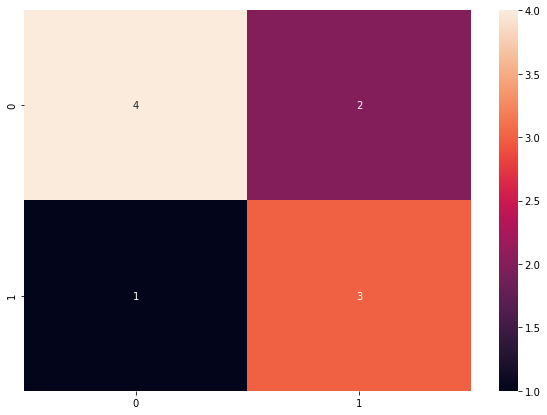

In [0]:

# fail나면 root계정에서  "pip install seaborn" 명령 실행할 것. 

import seaborn as sn

df_cm = pd.DataFrame(results, range(2),
                  range(2))
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, annot=True)